In [1]:
import os
import errno
import random
import shutil
import zipfile
import skimage.io as io

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import make_training_data
from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_sample
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
CHANNEL_AXIS = 3
training_data = np.load(os.path.join('/data/npz_data', 
                                     "Decidua_Object_Train_Val_Small_Nuclei" + ".npz"))

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))


X.shape: (6, 1024, 1024, 6) & y.shape: (6, 1024, 1024, 1)


In [3]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

norm_method = 'std'  # data normalization
receptive_field = 81  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance "classes"
erosion_width = 1  # erode edges

In [4]:
hist = np.load('/data/models/20190808_decidua_small_nuclei/Decidua_Object_Train_Small_Nuclei_watershed_fgbg_81_rf_64_conv_256_dense_300k.npz')
hist['loss_history'].tolist()['acc']

[0.8669245, 0.885312, 0.894747, 0.9003765, 0.9049005]

In [22]:
base_model_name = 'Decidua_Object_Train_Small_Nuclei'
folder_name = '20190808_decidua_small_nuclei'
epoch_name_watershed = "_epoch_01"

watershed_MODEL_NAME = base_model_name + '_watershed_81_rf_64_conv_256_dense_300k_5bins'  + epoch_name_watershed
watershed_weights_file = os.path.join('/data/models', folder_name, watershed_MODEL_NAME + ".h5")

fgbg_MODEL_NAME = base_model_name + '_watershed_fgbg_81_rf_64_conv_256_dense_300k'  + epoch_name_watershed
fgbg_weights_file = os.path.join('/data/models', folder_name, fgbg_MODEL_NAME + ".h5")

In [23]:
# load fgbg model
from deepcell import model_zoo
run_fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=81,
    dilated=True,
    n_features=2,
    input_shape=tuple(X.shape[1:]))
run_fgbg_model.load_weights(fgbg_weights_file)

In [24]:
test_images_fgbg = run_fgbg_model.predict(X[:1, ...])

In [25]:
np.save(os.path.join('/data/models', folder_name, fgbg_MODEL_NAME + "_metrics"), test_images_fgbg)

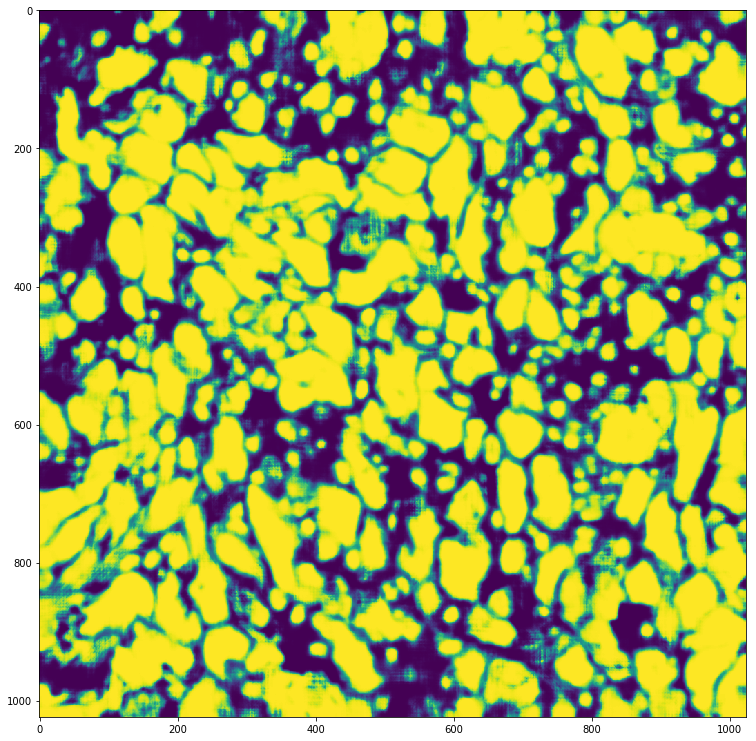

In [28]:
plt.figure(figsize = (13, 13))
plt.imshow(test_images_fgbg[0, :, :, 1])

In [7]:
# load sample model
from deepcell import model_zoo
run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_file)

In [8]:
# run the model
test_images = run_watershed_model.predict(X[:1, ...])

In [9]:
np.save(os.path.join('/data/models', folder_name, watershed_MODEL_NAME + "_metrics"), test_images)

In [10]:
argmax_images = []
for j in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

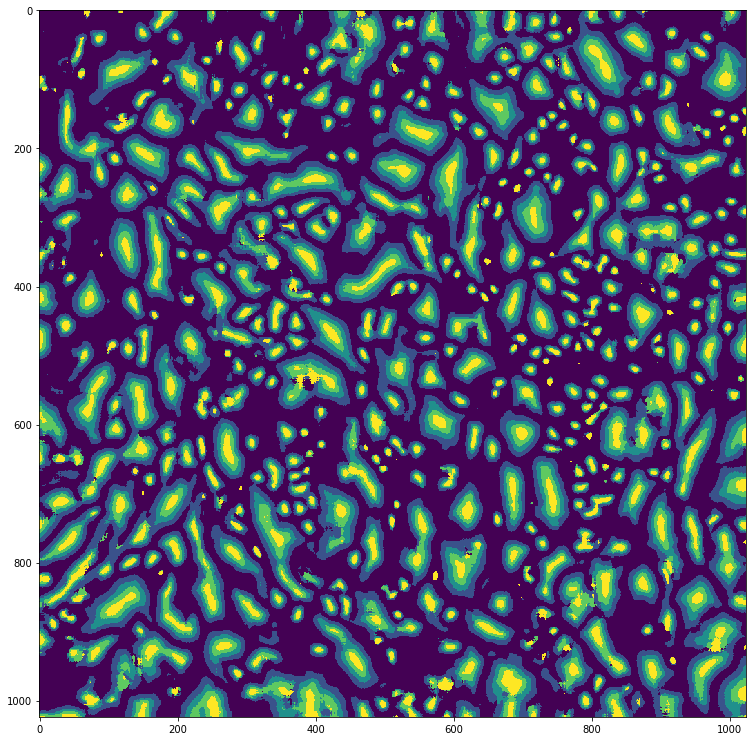

In [11]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])

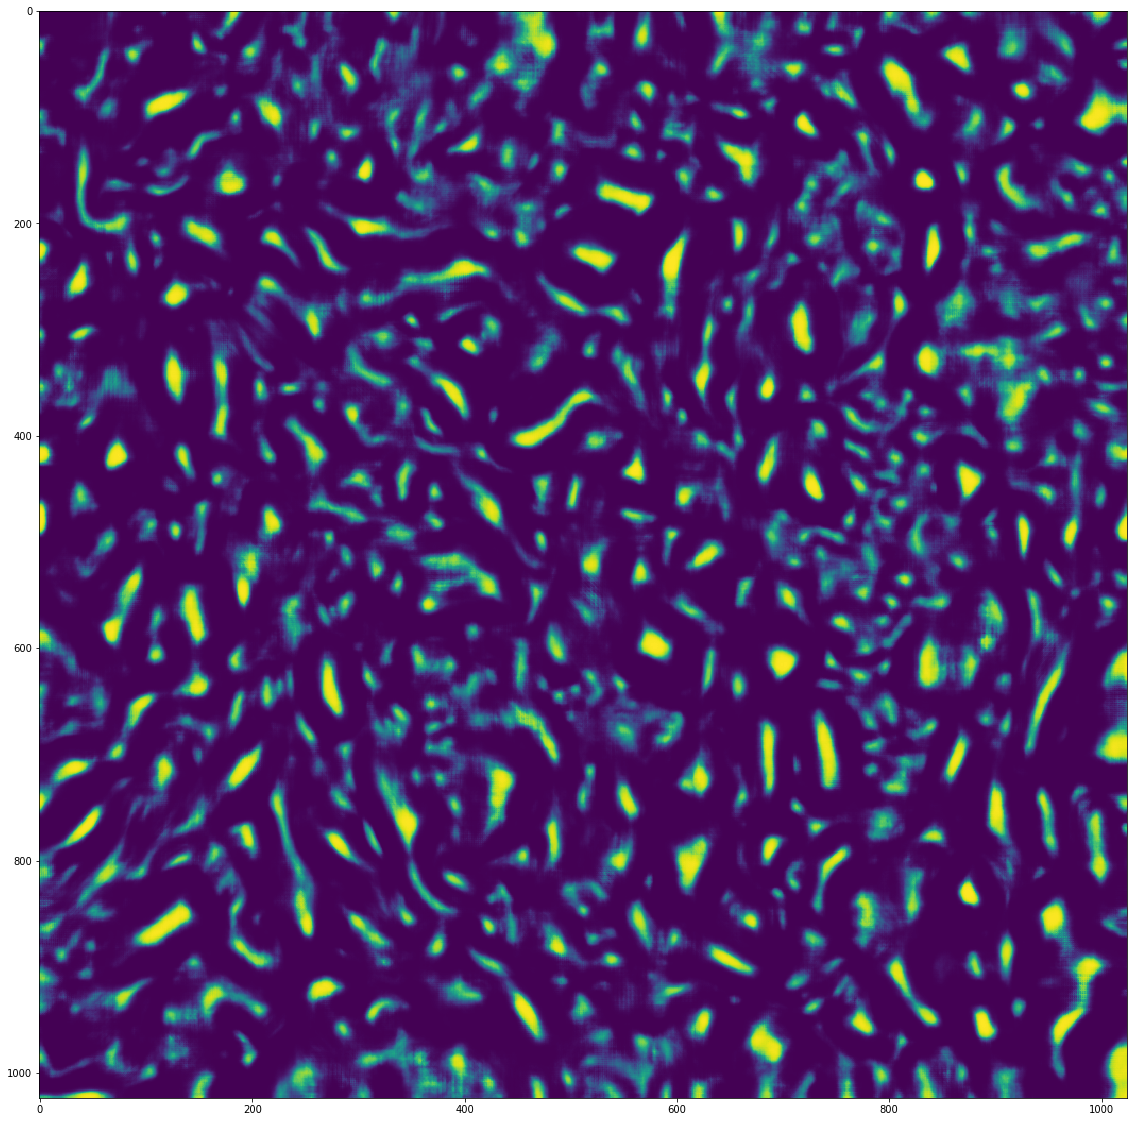

In [17]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 3])